# DIST-ALERT V1 Performance Assessment

#### Import functions

In [1]:
# Import strata and sample unit information
import sys 
import math
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mapsource = "mapLabels2023"
ANNname = "2023"
sampleDict = {}
sampleFull = {}
strata = {}
strataNoAlert = {}
landcoverS = {}
lossyear = {}
with open("sampledpixels_original.csv","r") as sample:
  lines = sample.readlines()[1:]
  for l in lines:
    (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
    sampleDict[ID] = ",".join([Long,Lat,zone,centxUTM,centyUTM])
    sampleFull[ID] = l.strip()
    strata[ID] = int(Stratum)
    if Stratum == "1":
      strataNoAlert[ID] = "1_"+landcover
    landcoverS[ID] = int(landcover)
    lossyear[ID] = int(forestLossYear)+2000
allIDs = sampleDict.keys()

#Strata area
strataAreas = {}
strataCounts = {}
allStrata = []
totalArea = 0
with open("stratatable_nosplit.txt","r") as file:
  lines = file.readlines()[1:]
for l in lines:
  (s,count,area,K,zcount) = l.strip().split("\t")
  strataAreas[s] = float(area)
  strataCounts[s] = math.ceil(float(area)/(900/1000000))
  allStrata.append(int(s))
  totalArea += float(area)
Nstrata = len(strataCounts)

with open("stratatable.txt","r") as file:
  lines = file.readlines()[1:]

for l in lines:
  (s,count,area,K,zcount) = l.strip().split("\t")
  if int(s)%5 == 1:
    landcover = str(int((int(s)-1)/5)+1)
    strataAreas["1_"+landcover] = float(area)
    strataCounts["1_"+landcover] = math.ceil(float(area)/(900/1000000))


In [2]:
def selectByLandCover(landcoverlist=[1,2,3,4,5,6,7,8,9],split1=False):
  with open("sampledpixels_original.csv","r") as sample:
    lines = sample.readlines()[1:]
    selectedIDs = []
    foundStrata = {}
    for l in lines:
      (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
      if int(landcover) in landcoverlist:
        selectedIDs.append(ID)
        if split1 and Stratum == "1":
          foundStrata[Stratum] = "1_"+landcover
        else:
          foundStrata[Stratum] = int(Stratum)
  #outdict = {key: sampleDict[key] for key in selectedIDs}
  return (selectedIDs,foundStrata.values())

### Generic functions

In [3]:
def dayDiff(start,end):
  startdate = datetime.datetime.strptime(start,"%Y%m%d")
  enddate = datetime.datetime.strptime(end,"%Y%m%d")
  days = enddate-startdate
  return (days.days+1)

In [4]:
def getDISTALERTStatus_vI(skipNodata=False):
    #print(skipNodata)
    mapalert = {}
    for ID in allIDs:
        mapalert[ID] = [255 for i in range(0,366)]
        #print(ID,end=',')
        with open(mapsource+'/'+ID+'_DIST-ALERT_'+ANNname+'.csv','r') as mapfile:
            lines = mapfile.readlines()
            header = lines[0]
            maplist = lines[1:]
            for line in maplist:
                try:
                    (granuleID,SensingTime,ProductionTime,VEGDISTSTATUS,VEGANOM,VEGIND,VEGHIST,VEGANOMMAX,VEGDISTCONF,VEGDISTDATE,VEGDISTCOUNT,VEGDISTDUR,VEGLASTDATE,GENDISTSTATUS,GENANOM,GENANOMMAX,GENDISTCONF,GENDISTDATE,GENDISTCOUNT,GENDISTDUR,GENLASTDATE)= line.strip().split(',')
                    day = dayDiff("20230101",SensingTime)

                    if not (skipNodata and int(VEGANOM)==255):
                        if int(VEGDISTSTATUS) in [1,2,3,7] and int(VEGANOMMAX) < 10:
                            mapalert[ID][day] = 0
                        else:
                            mapalert[ID][day] = int(VEGDISTSTATUS)
                except:
                #    print(traceback)
                    print(ID,line)

    return mapalert

In [5]:
def filterMap(map,cat):
    mapout = {}

    if cat == "lt50":
        nodist = [0]
        dist = [1,2,3,4,5,6]
        old = [7,8]
    elif cat == "lt50_curr":
        nodist = [0]
        dist = [1,2,3,4,5,6]
        old = []
    elif cat == "provlt50":
        nodist = [0]
        dist = [2,3,5,6]
        old = [7,8]
    elif cat == "lt50_onlyprov":
        nodist = [0]
        dist = [2,5]
        old = []
    elif cat == "onlylt50":
        nodist = [0]
        dist = [1,2,3]
        old = [7]
    elif cat == "gt50":
        nodist = [0,1,2,3,7]
        dist = [4,5,6]
        old = [8]
    elif cat == "gt50_curr":
        nodist = [0,1,2,3,7]
        dist = [4,5,6]
        old = []
    elif cat == "provgt50":
        nodist = [0,1,2,3,7]
        dist = [5,6]
        old = [8]
    elif cat == "gt50_onlyprov":
        nodist = [0,1,2,3,7]
        dist = [5]
        old = []
    elif cat == "confgt50":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = [8]
    elif cat == "provgt50_curr":
        nodist = [0,1,2,3,7]
        dist = [5,6]
        old = []  
    elif cat == "confgt50_curr":
        nodist = [0,1,2,3,7]
        dist = [6]
        old = []
    elif cat == "conflt50":
        nodist = [0]
        dist = [3,6]
        old = [7,8]
    elif cat == "conflt50_curr":
        nodist = [0]
        dist = [3,6]
        old = []
    else:
        print(cat, "not found")
    for ID in allIDs:
        mapout[ID] = [0 for x in range(0,366)]
        for d in range(0,366):
            if map[ID][d] in nodist:
                mapout[ID][d] = 1
            elif map[ID][d] in dist:   
                mapout[ID][d] = 2
            elif map[ID][d] in old:
                mapout[ID][d] = 3
            else:
                mapout[ID][d] = 0
    return mapout

In [6]:
def getRefALERTbinaryDaily(filename,yeslabels,nolabels,IDlist=allIDs,conversiononly=False,only2023=False):
  if conversiononly or only2023:
    with open("reference_conversion.csv","r") as reffile:
      reflist = reffile.readlines()[1:]
    refconv = {}
    refprevyear = {}
    natural = {}
    for line in reflist:
      fields = line.strip().split(",")
      (ID,changetype,conversion,naturalproportion,prevyear,overallLabel)=fields[0:6]
      refconv[ID]=conversion
      refprevyear[ID]=prevyear
      natural[ID] = naturalproportion
  refalert = {}
  with open(filename,"r") as mapfile:
    lines = mapfile.readlines()
    header = lines[0]
    reflist = lines[1:]
  for line in reflist:
    fields = line.strip().split(",")
    (ID,overallLabel,Long,Lat,changetype) = fields[0:5]
    refalert[ID] = [0 for i in range(0,366)]
    if ID in IDlist:
      daily = fields[5:]
      #refalert[ID] = [0 for i in range(0,366)]
      try:
        for day in range(0,366):
          found = False
          for l in yeslabels:
            if l == daily[day]:
              found = True
            #if l in daily[day] and int(ID) in refVLmaj:
            #  found = True
          if found:
            refalert[ID][day] = 2
          else:
            for l in nolabels:
              if l == daily[day]:
                found = True
            if found:
              refalert[ID][day] = 1
            else:
              refalert[ID][day] = 0
          if conversiononly and (refconv[ID] != "natural" and (refconv[ID] != "human" or (refconv[ID] == "human" and natural[ID] == '0'))):#(refconv[ID] != "human" or (refconv[ID] == "human" and natural[ID] == '0')):#(refconv[ID] == "no" or natural[ID] == '0'):
            refalert[ID][day] = 0
          if only2023 and refprevyear[ID] == "TRUE":
            refalert[ID][day] = 0
      except:
        print(ID,day,daily)
  return refalert

In [7]:
def alertConfusionMatrix_vTS2(map,ref,mincount,Ndays,name,IDlist=allIDs,selectedStrata=allStrata,printMatrix = False,excludelist=[]):
  N = strataCounts
  Nstrata = len(allStrata)
  maxStrata = max(allStrata)
  Ntotal = sum([N[str(s)] for s in allStrata])
  n = {s:[[0,0,0],[0,0,0],[0,0,0]] for s in allStrata}
  ntotal = {s:0 for s in allStrata}
  with open(name+".txt","w") as OUT:
    OUT.write("ID,agree_no,commission,omission,agree_loss,total\n")

  #confusion matrix
  for ID in IDlist:
    try:
      p = [[0,0,0],[0,0,0],[0,0,0]]
      ptotal = 0
      for d in range(0,365):
        if not int(ID) in excludelist:
          if max(ref[ID][0:(d+1)])>0 and map[ID][d] != 255:
              start = (d>Ndays)*(d-Ndays)
              if map[ID][d] == 1:
                  mapVal=1
                  if ref[ID][start:(d+mincount)].count(2) > mincount:
                      refVal=2
                  elif ref[ID][start:(d+1)].count(1) > 0:
                      refVal=1
                  else:
                      refVal=0
              elif map[ID][d] == 2:
                  mapVal=2
                  if ref[ID][start:(d+mincount)].count(2) > mincount:
                      refVal=2
                  elif ref[ID][start:(d+1)].count(1) > 0:
                      refVal=1
                  else:
                      refVal=0
              elif map[ID][d] == 3:
                  mapVal=2
                  if ref[ID][0:(d+mincount)].count(2) > mincount:
                      refVal=2
                  else:
                      refVal=1
              else:
                  mapVal=0
                  refVal=0
              if refVal>0 and mapVal>0:
                  p[refVal][mapVal] += 1
                  ptotal += 1
      if ptotal>0:
        if p[1][2] >0 or p[2][1] >0:  
          with open(name+".txt","a") as OUT:
            OUT.write(str(ID)+","+str(p[1][1])+","+str(p[1][2])+","+str(p[2][1])+","+str(p[2][2])+","+str(ptotal)+"\n")
        ntotal[strata[ID]] += 1
        for r in [1,2]:
          for m in [1,2]:
            n[strata[ID]][r][m] += (p[r][m]/ptotal)
    except:
      print(ID,"missing",strata[ID],d,p,ptotal,ntotal[strata[ID]])
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in allStrata:
      if ntotal[s]>0:
        print(s,end=":")
        for r in (1,2):
          for m in (1,2):
            print(n[s][r][m],end=",")
        print()
  return (n,ntotal)

In [8]:
def usersAccuracy(n, ntotal, name, selectedStrata=allStrata, write=True):
  N = strataCounts
  Nstrata = len(selectedStrata)

  #Accuracy
  y = 0
  usersx = 0
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if ntotal[s]>0:
      y += (n[s][2][2]/ntotal[s])*N[str(s)]
      usersx += ((n[s][1][2]+n[s][2][2])/ntotal[s])*N[str(s)]
  if usersx > 0:
    users = (y/usersx)
  else:
    users = "NA"
    usersSE = "NA"

  UAsub1 = 0
  UAsub2 = 0
  if users != "NA":
    for s in selectedStrata:
      if "_" in str(s):
        stringS = s
        s = int(s.split("_")[1])
      else:
        stringS = str(s)
      if (n[s][1][2]+n[s][2][2]) > 0 and ntotal[s]>1:
        yhmean = n[s][2][2]/ntotal[s]
        yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)
        xuhmean = (n[s][1][2]+n[s][2][2])/ntotal[s]
        xuhsampvar = ((n[s][1][2]+n[s][2][2])*((1-xuhmean)**2) + (n[s][1][1] + n[s][2][1])*((0-xuhmean)**2))/(ntotal[s]-1)
        xyuhsampvar = (n[s][1][1] * (0-yhmean) * (0-xuhmean) + n[s][1][2] * (0-yhmean) * (1-xuhmean) + n[s][2][1] * (0-yhmean) * (0-xuhmean) + n[s][2][2] * (1-yhmean) * (1-xuhmean))/(ntotal[s] - 1)
        UAsub1 += N[stringS]*xuhmean
        UAsub2 += N[stringS]**2 * (1 - ntotal[s]/N[stringS]) * (yhsampvar + (users**2)*xuhsampvar - 2*users*xyuhsampvar)/ntotal[s]
  
  if users != "NA":
    if UAsub1>0 and UAsub2>0:
        usersSE = math.sqrt(1/(UAsub1**2) * UAsub2) * 100
    else:
        usersSE = math.nan
    users = users*100
  else:
    users = math.nan
    usersSE = math.nan
  return [users,usersSE]


In [9]:
def producersAccuracy(n, ntotal, name, selectedStrata=allStrata, write=True):
  N = strataCounts
  Nstrata = len(selectedStrata)
  Ntotal = sum([N[str(s)] for s in selectedStrata])

  #Accuracy
  y = 0
  producersx = 0
  for s in selectedStrata:
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if ntotal[s]>0:
      y += (n[s][2][2]/ntotal[s])*N[str(s)]
      producersx += ((n[s][2][1]+n[s][2][2])/ntotal[s])*N[stringS]
  if producersx > 0:
    producers = (y/producersx)
  else:
    producers = "NA"
    producersSE = "NA"

  PAsub1 = 0
  PAsub2 = 0
  for s in selectedStrata:
    #users and producers
    if "_" in str(s):
      stringS = s
      s = int(s.split("_")[1])
    else:
      stringS = str(s)
    if producers != "NA":
        if (n[s][2][1]+n[s][2][2]) > 0 and ntotal[s]>1:
            yhmean = n[s][2][2]/ntotal[s]
            yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)
            xphmean = (n[s][2][1]+n[s][2][2])/ntotal[s]
            xphsampvar = ((n[s][2][1]+n[s][2][2])*((1-xphmean)**2) + (n[s][1][1] + n[s][1][2])*((0-xphmean)**2))/(ntotal[s]-1)
            xyphsampvar = (n[s][1][1] * (0-yhmean) * (0-xphmean) + n[s][1][2] * (0-yhmean) * (0-xphmean) + n[s][2][1] * (0-yhmean) * (1-xphmean) + n[s][2][2] * (1-yhmean) * (1-xphmean))/(ntotal[s] - 1)
            PAsub1 += N[stringS]*xphmean
            PAsub2 += N[stringS]**2 * (1 - ntotal[s]/N[stringS]) * (yhsampvar + (producers**2)*xphsampvar - 2*producers*xyphsampvar)/ntotal[s]
  
  if producers != "NA":
    if PAsub1 >0 and PAsub2>0:
      producersSE = math.sqrt(1/(PAsub1**2) * PAsub2) * 100
    else:
      producersSE = math.nan
    producers = producers*100
  else:
    producers = math.nan
    producersSE = math.nan#"NA"

  return [producers,producersSE]

## Accuracy for all land cover combined and original land cover strata

#### Calculate accuracy per land cover stratum

In [10]:
map = getDISTALERTStatus_vI(True)

1323 OPERA_L3_DIST-ALERT-HLS_T19HFC_20230219T142709Z_20231221T042133Z_S2B_30_v1_VEG-DIST-STATUS,20230219,2023-12-21 04:21:33,,,,,,


In [11]:
mapsource = "mapLabels2023"
land = {1:"builtup",2:"treestable",3:"treedisturb",4:"crop",5:"wetland",6:"hishortveg",7:"lowshortveg",8:"other"}
Adict = {}
U= {}
USE = {}
P = {}
PSE = {}
simple = {}
for cattype in ["lt50","conflt50","gt50","confgt50","provgt50","provlt50","gt50_onlyprov","lt50_onlyprov"]:
  mapsimple = filterMap(map,cattype)
  for duration in [10]:#,5,10,15]:
    for lookback in [30]:#1,15,30]: 
        name = cattype+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal"],noLabels,conversiononly=False)
        Adict[name]=""
        U[name]=[]
        USE[name]=[]
        P[name]=[]
        PSE[name]=[]
        simple[name]=""
        for lc in [[1],[2],[3],[4],[5],[6],[7],[8],"all"]:
          if lc == "all":
            (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)
          else:
            (selectedIDs,selectedStrata) = selectByLandCover(lc,True)
          (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name,selectedIDs,selectedStrata)
          (producers,producersSE) = producersAccuracy(n, ntotal, name,selectedStrata)
          (users,usersSE) = usersAccuracy(n, ntotal, name,selectedStrata)
          Adict[name] = Adict[name]+str(users)+","+str(usersSE)+","+str(producers)+","+str(producersSE)+","
          U[name].append(users)
          USE[name].append(usersSE)
          P[name].append(producers)
          PSE[name].append(producersSE)
          simple[name]=simple[name]+str(producers)+","

        name = cattype+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
        noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal","VLmin"],noLabels,conversiononly=False)#referenceTimeSeriesInterpolated11_last.csv
        Adict[name]=""
        U[name]=[]
        USE[name]=[]
        P[name]=[]
        PSE[name]=[]
        simple[name]=""
        for lc in [[1],[2],[3],[4],[5],[6],[7],[8],"all"]:
          if lc == "all":
            (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)
          else:
            (selectedIDs,selectedStrata) = selectByLandCover(lc,True)
          (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name,selectedIDs,selectedStrata)
          (producers,producersSE) = producersAccuracy(n, ntotal, name,selectedStrata)
          (users,usersSE) = usersAccuracy(n, ntotal, name,selectedStrata)
          Adict[name] = Adict[name]+str(users)+","+str(usersSE)+","+str(producers)+","+str(producersSE)+","
          U[name].append(users)
          USE[name].append(usersSE)
          P[name].append(producers)
          PSE[name].append(producersSE)
          simple[name]=simple[name]+str(users)+","

for n in Adict.keys():
  print(n+","+Adict[n])
print("\n")
for n in Adict.keys():
  print(n+","+simple[n])

lt50_lookback30_duration10,7.44868849539629,3.609048619167786,98.13827978658968,3.206280473879379,12.495784192401494,5.420428445118477,94.83110231624164,5.141271657751897,24.403086339982078,5.307162567353101,96.51581459962534,5.208548475278427,14.243814036246578,5.034778844475966,90.3153112906424,16.65825930330861,7.296495206624547,3.495940418636598,99.1189523824748,3.2071375985245023,20.80571091944503,8.021655591976948,99.44401452923526,3.586946791885969,0.8580823343925441,0.43931932580912186,96.7170559561978,8.38749983027514,2.088055242370597,1.4641109101243008,76.91877511465496,45.689349525709694,13.475167413016372,2.7272252277702194,96.19940045126317,4.29121434445686,
lt50_lookback30_duration10_VLmin,64.90188148049587,12.068038330022718,70.23591474181207,11.624296780956707,45.12349183995023,15.235172884593274,49.83889778124326,15.422529541904751,75.75694217833411,8.806109329821782,72.11278744163518,7.8789609246422865,77.52929193527694,8.881712425161268,70.99925772526097,9.405641629

#### Plot accuracy of each land cover strata

/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


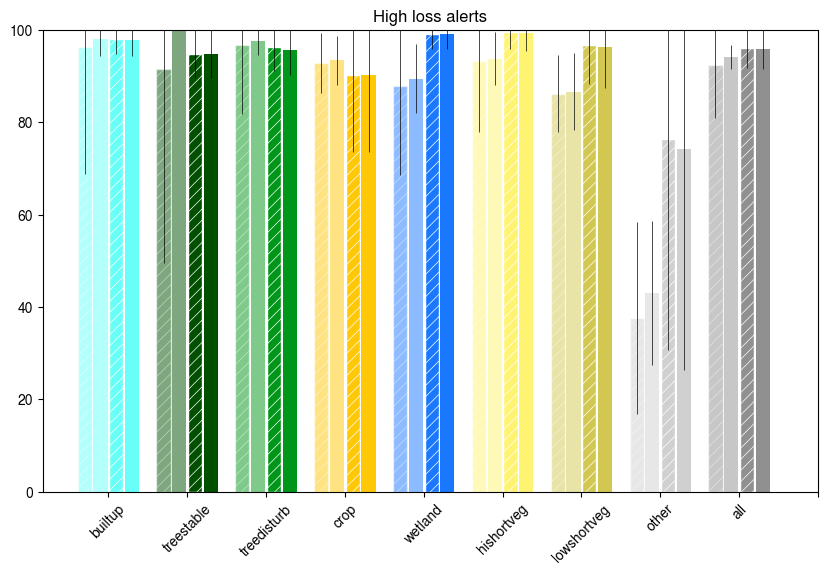

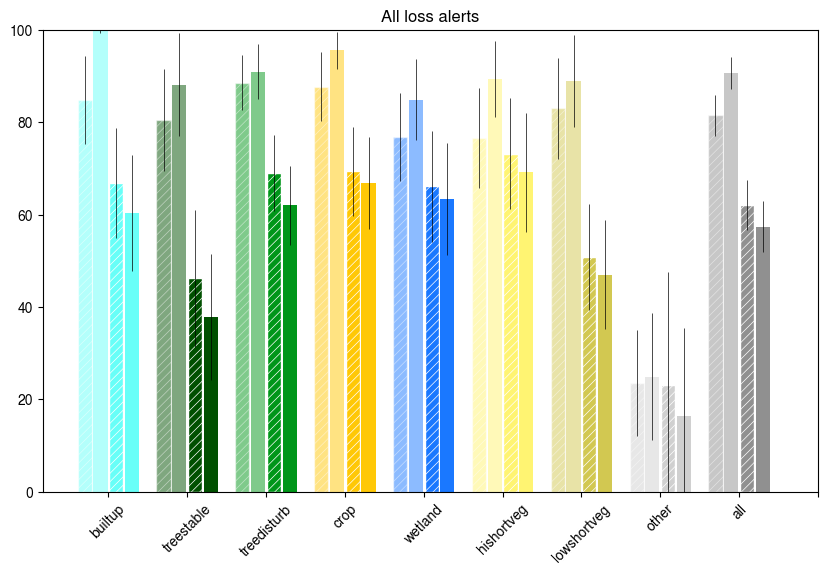

In [12]:
#accuracy 
import pandas as pd
import matplotlib
matplotlib.style.use('default')

dfU = pd.DataFrame(U.values())
dfUSE = pd.DataFrame(USE.values())
dfP = pd.DataFrame(P.values())
dfPSE = pd.DataFrame(PSE.values())

lookback = '30'
duration = '10'

df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","all"],
                   U["provgt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   U["confgt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   P["provlt50_lookback"+lookback+"_duration"+duration],
                   P["conflt50_lookback"+lookback+"_duration"+duration]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersconf","prod","prodconf"]

strats = ["builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","all"]#"water"
#print(df["userslt50"])
x = np.arange(len(strats))
width=0.2
#print(x)

fig, ax = plt.subplots(figsize=(10,6))
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams['hatch.linewidth'] = 0.5
palette = ["#68fff8","#005000","#009619","#ffc806","#1A78FF","#fff472","#d2c851","#d0d0d0","#909090"]
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=USE["gt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=USE["confgt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=PSE["lt50_lookback"+lookback+"_duration"+duration],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=PSE["conflt50_lookback"+lookback+"_duration"+duration],color=palette,error_kw=dict(lw=0.5))
#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("High loss alerts")
fig.show()


df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","all"],
                   U["provlt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   U["conflt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   P["provlt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   P["conflt50_lookback"+lookback+"_duration"+duration+"_VLmin"]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersconf","prod","prodconf"]

fig, ax = plt.subplots(figsize=(10,6))
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams['hatch.linewidth'] = 0.5
palette = ["#68fff8","#005000","#009619","#ffc806","#1A78FF","#fff472","#d2c851","#d0d0d0","#909090"]
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=USE["provlt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='////',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=USE["conflt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=PSE["provlt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,error_kw=dict(lw=0.5),hatch='////',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=PSE["conflt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,error_kw=dict(lw=0.5))
#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("All loss alerts")
fig.show()


### Conversion

In [13]:
## filter samples to only include conversion samples
## calculate accuracy for all strata together
land = {1:"builtup",2:"treestable",3:"treedisturb",4:"crop",5:"wetland",6:"hishortveg",7:"lowshortveg",8:"other",9:"water",'all':'all'}
for cattype in ["lt50","conflt50","gt50","confgt50","provgt50","provlt50","gt50_onlyprov","lt50_onlyprov"]:
  mapsimple = filterMap(map,cattype)
  for duration in [10]:#,5,10,15]:
    for lookback in [30]:#1,15,30]: 
        (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)#,7
        name = cattype+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal"],noLabels,conversiononly=True,only2023=True)
        (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name,selectedIDs,selectedStrata)
        (producers,producersSE) = producersAccuracy(n, ntotal, name,selectedStrata)
        (users,usersSE) = usersAccuracy(n, ntotal, name,selectedStrata)
        print(name+","+str(users)+","+str(usersSE)+","+str(producers)+","+str(producersSE))
        
        name = cattype+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
        noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal","VLmin"],noLabels,conversiononly=True,only2023=True)#referenceTimeSeriesInterpolated11_last.csv
        (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name,IDlist=selectedIDs)
        (producers,producersSE) = producersAccuracy(n, ntotal, name,list(selectedStrata))
        (users,usersSE) = usersAccuracy(n, ntotal, name,list(selectedStrata))
        print(name+","+str(users)+","+str(usersSE)+","+str(producers)+","+str(producersSE))

lt50_lookback30_duration10,15.967530569603253,8.08727997823258,99.21636189971925,1.9245964809000975
lt50_lookback30_duration10_VLmin,93.80929525548805,12.432580330271158,77.73235257408243,19.55562341648343
conflt50_lookback30_duration10,25.178079615837202,14.295906917870576,99.15932789528941,1.9272629753722306
conflt50_lookback30_duration10_VLmin,98.34785777982785,9.221500040299391,59.01876569942869,22.62390201118158
gt50_lookback30_duration10,75.24760285309185,24.061476380928113,85.7656841109376,16.569422760566592
gt50_lookback30_duration10_VLmin,99.21456173576148,1.8849414516361234,15.937264916766292,7.30083858578787
confgt50_lookback30_duration10,79.2085104076228,22.333197187222847,85.69841418218799,16.627558765579582
confgt50_lookback30_duration10_VLmin,100.0,nan,15.320737110859245,7.142890511120581
provgt50_lookback30_duration10,77.8667766274592,22.791998761738117,85.80577423580424,16.556579600215564
provgt50_lookback30_duration10_VLmin,99.58677161836282,1.3837774391271536,15.5626

'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


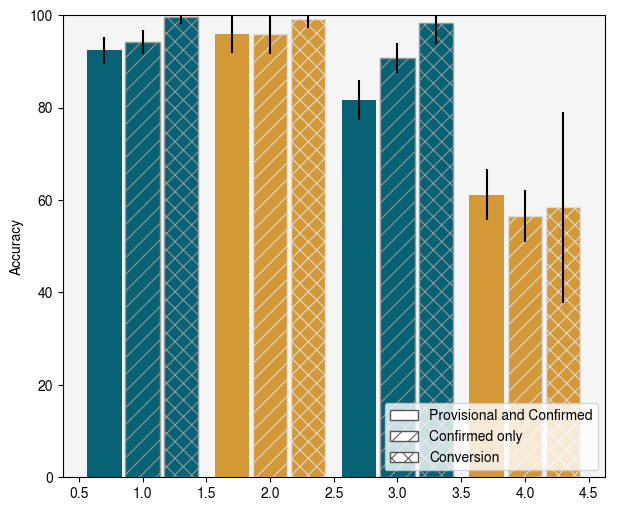

In [14]:
data = [["Users",92.4,	2.9],
["Confirmed Users",94.3,	2.6],
["Producers",96,	4.2],
["Confirmed Producers",95.9,	4.3],
["AUsers",81.6,	4.3],
["Aconfirmed Users",90.7,	3.3],
["Prod",61.2,	5.5],
["Aconfirmed Prod",56.6,	5.6]]

LUexp = [["Converted Users",100.0,	0],
["Converted, Prod",100,	0],
["Aconverted Users",99.5,	2.6],
["Aconverted Prod",74.0,25.2]]

NandH = [["Converted Users",99.6,	1.4],
["Converted, Prod",99.2,1.9],
["Aconverted Users",98.4,	4.7],
["Aconverted Prod",58.4,20.7]]

NandLUexp = [["Converted Users",99.6,	1.5],
["Converted, Prod",99.2,2.0],
["Aconverted Users",97.6,	8.2],
["Aconverted Prod",73.8,23.4]]
         
converted = NandH#LUexp
data = [data[0],data[1],converted[0],data[2],data[3],converted[1],data[4],data[5],converted[2],data[6],data[7],converted[3]]

df = pd.DataFrame(data,columns=["name","val","SE"])

fig, ax = plt.subplots(figsize=(7,6))
plt.grid(False)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams['hatch.linewidth'] = 0.75
pal = ["#066274","#D49937"]
pal = [pal[0],pal[0],pal[1],pal[1],pal[0],pal[0],pal[1],pal[1]]
width =0.3
ax.bar(1-width,df["val"][0],width-width*0.1,yerr=df["SE"][0],color=pal[0],error_kw=dict(lw=1.5))#,hatch='///',edgecolor="white")
ax.bar(1,df["val"][1],width-width*0.1,yerr=df["SE"][1],color=pal[1],error_kw=dict(lw=1.5),hatch='//',edgecolor="#999999")
ax.bar(1+width,df["val"][2],width-width*0.1,yerr=df["SE"][2],color=pal[1],error_kw=dict(lw=1.5),hatch='xx',edgecolor="#999999")
ax.bar(2-width,df["val"][3],width-width*0.1,yerr=df["SE"][3],color=pal[2],error_kw=dict(lw=1.5))#,hatch='///',edgecolor="white")
ax.bar(2,df["val"][4],width-width*0.1,yerr=df["SE"][4],color=pal[3],error_kw=dict(lw=1.5),hatch='//',edgecolor="#dddddd")
ax.bar(2+width,df["val"][5],width-width*0.1,yerr=df["SE"][5],color=pal[3],error_kw=dict(lw=1.5),hatch='xx',edgecolor="#dddddd")
ax.bar(3-width,df["val"][6],width-width*0.1,yerr=df["SE"][6],color=pal[4],error_kw=dict(lw=1.5))#,hatch='///',edgecolor="white")
ax.bar(3,df["val"][7],width-width*0.1,yerr=df["SE"][7],color=pal[5],error_kw=dict(lw=1.5),hatch='//',edgecolor="#999999")
ax.bar(3+width,df["val"][8],width-width*0.1,yerr=df["SE"][8],color=pal[5],error_kw=dict(lw=1.5),hatch='xx',edgecolor="#999999")
ax.bar(4-width,df["val"][9],width-width*0.1,yerr=df["SE"][9],color=pal[6],error_kw=dict(lw=1.5))#,hatch='///',edgecolor="white")
ax.bar(4,df["val"][10],width-width*0.1,yerr=df["SE"][10],color=pal[7],error_kw=dict(lw=1.5),hatch='//',edgecolor="#dddddd")
ax.bar(4+width,df["val"][11],width-width*0.1,yerr=df["SE"][11],color=pal[7],error_kw=dict(lw=1.5),hatch='xx',edgecolor="#dddddd")
ax.set_ylim([0, 100])
ax.set_facecolor("#f5f5f5")
ax.set_ylabel("Accuracy")

import matplotlib.patches as mpatches
all = mpatches.Patch(facecolor='#ffffff', label='Provisional and Confirmed',edgecolor="#555555")
conf = mpatches.Patch(facecolor='#ffffff', label='Confirmed only',hatch='//',edgecolor="#555555")
conv = mpatches.Patch(facecolor='#ffffff', label='Conversion',hatch='xx',edgecolor="#555555")
ax.legend(handles=[all,conf,conv],loc="lower right")

plt.savefig("accuracyAllOnly.pdf",bbox_inches='tight')
fig.show()

## Accuracy for land cover strata plus water

#### Import functions

In [15]:
# Import strata and sample unit information
import sys 
import math
import datetime
import pandas as pd

mapsource = "mapLabels2023"
ANNname = "2023"
sampleDict = {}
sampleFull = {}
strata = {}
strataNoAlert = {}
landcoverS = {}
lossyear = {}
with open("sampledpixels_water.csv","r") as sample:
  lines = sample.readlines()[1:]
  for l in lines:
    (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
    sampleDict[ID] = ",".join([Long,Lat,zone,centxUTM,centyUTM])
    sampleFull[ID] = l.strip()
    strata[ID] = int(Stratum)
    if Stratum == "1":
      strataNoAlert[ID] = "1_"+landcover
    landcoverS[ID] = int(landcover)
    lossyear[ID] = int(forestLossYear)+2000
allIDs = sampleDict.keys()

#Strata area
strataAreas = {}
strataCounts = {}
allStrata = []
totalArea = 0
with open("stratatable_water_nosplit.txt","r") as file:
  lines = file.readlines()[1:]
for l in lines:
  (s,count,area,K) = l.strip().split("\t")
  strataAreas[s] = float(area)
  strataCounts[s] = math.ceil(float(area)/(900/1000000))
  allStrata.append(int(s))
  totalArea += float(area)
Nstrata = len(strataCounts)

with open("stratatable_water.txt","r") as file:
  lines = file.readlines()[1:]

for l in lines:
  (s,count,area,K) = l.strip().split("\t")
  if int(s)%5 == 1:
    landcover = str(int((int(s)-1)/5)+1)
    strataAreas["1_"+landcover] = float(area)
    strataCounts["1_"+landcover] = math.ceil(float(area)/(900/1000000))


In [16]:
def selectByLandCoverWater(landcoverlist=[1,2,3,4,5,6,7,8,9],split1=False):
  with open("sampledpixels_water.csv","r") as sample:
    lines = sample.readlines()[1:]
    selectedIDs = []
    foundStrata = {}
    for l in lines:
      (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
      if int(landcover) in landcoverlist:
        selectedIDs.append(ID)
        if split1 and Stratum == "1":
          foundStrata[Stratum] = "1_"+landcover
        else:
          foundStrata[Stratum] = int(Stratum)
  return (selectedIDs,foundStrata.values())

#### Accuracy per land cover stratum

In [17]:
land = {1:"builtup",2:"treestable",3:"treedisturb",4:"crop",5:"wetland",6:"hishortveg",7:"lowshortveg",8:"other",9:"water"}
Adict = {}
U= {}
USE = {}
P = {}
PSE = {}
simple = {}
for cattype in ["lt50","conflt50","gt50","confgt50","provgt50","provlt50"]:
  mapsimple = filterMap(map,cattype)
  for duration in [10]:#,5,10,15]:
    for lookback in [30]:#1,15,30]: 
        name = cattype+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal"],noLabels,conversiononly=False)
        Adict[name]=""
        U[name]=[]
        USE[name]=[]
        P[name]=[]
        PSE[name]=[]
        simple[name]=""
        for lc in [[1],[2],[3],[4],[5],[6],[7],[8],[9],"all"]:
          if lc == "all":
            (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)
          else:
            (selectedIDs,selectedStrata) = selectByLandCoverWater(lc,True)
          (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name,selectedIDs,selectedStrata)
          (producers,producersSE) = producersAccuracy(n, ntotal, name,selectedStrata)
          (users,usersSE) = usersAccuracy(n, ntotal, name,selectedStrata)
          Adict[name] = Adict[name]+str(users)+","+str(usersSE)+","+str(producers)+","+str(producersSE)+","
          U[name].append(users)
          USE[name].append(usersSE)
          P[name].append(producers)
          PSE[name].append(producersSE)
          simple[name]=simple[name]+str(producers)+","

        name = cattype+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
        noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal","VLmin"],noLabels,conversiononly=False)
        Adict[name]=""
        U[name]=[]
        USE[name]=[]
        P[name]=[]
        PSE[name]=[]
        simple[name]=""
        for lc in [[1],[2],[3],[4],[5],[6],[7],[8],[9],"all"]:
          if lc == "all":
            (selectedIDs,selectedStrata) = selectByLandCover([1,2,3,4,5,6,7,8],False)
          else:
            (selectedIDs,selectedStrata) = selectByLandCoverWater(lc,True)
          (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name,selectedIDs,selectedStrata)
          (producers,producersSE) = producersAccuracy(n, ntotal, name,selectedStrata)
          (users,usersSE) = usersAccuracy(n, ntotal, name,selectedStrata)
          Adict[name] = Adict[name]+str(users)+","+str(usersSE)+","+str(producers)+","+str(producersSE)+","
          U[name].append(users)
          USE[name].append(usersSE)
          P[name].append(producers)
          PSE[name].append(producersSE)
          simple[name]=simple[name]+str(users)+","

for n in Adict.keys():
  print(n+","+Adict[n])
print("\n")
for n in Adict.keys():
  print(n+","+simple[n])

lt50_lookback30_duration10,7.44868849539629,3.609048619167786,98.13827978658968,3.206280473879379,12.495784191889259,5.420428445040783,94.83110231624164,5.141271657751897,24.403086339982078,5.307162567353101,96.51581459962534,5.208548475278427,14.243814036246578,5.034778844475966,90.3153112906424,16.65825930330861,7.296495206624547,3.495940418636598,99.1189523824748,3.2071375985245023,20.80571091988201,8.021655592065008,99.44401452923526,3.586946791885969,0.8580823343925441,0.43931932580912186,96.7170559561978,8.38749983027514,2.583511483587019,2.17201927760797,74.05261195826706,49.165504754762814,1.4983754547521768,1.6221641860819325,100.0,nan,13.502465303073679,2.7340594728194523,96.20092257902945,4.29207806123861,
lt50_lookback30_duration10_VLmin,64.90188148049587,12.068038330022718,70.23591474181207,11.624296780956707,45.12349183820989,15.235172884816173,49.838897779922384,15.422529542363408,75.75694217833411,8.806109329821782,72.11278744163518,7.8789609246422865,77.52929193527694,

     landcover    users usersconf     prod prodconf
9          all  92.4491   94.2025  96.1126  95.9307
1   treestable  91.4847       100  94.7496   94.718
2  treedisturb   96.695   97.6255  96.3068  95.7316
5   hishortveg  93.1824   93.7567    99.43   99.377
6  lowshortveg  86.1586   86.5702  96.6242  96.3092
0      Builtup  96.3362   98.0527  98.0232  97.7489
3         crop  92.8241    93.429  90.2433  90.1857
4      wetland  87.7361   89.4075  99.1138  99.0657
8        water  26.2722   28.0207      100      100
7        other  61.8056    83.872  73.5423  71.0226


'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


     landcover    users usersconf     prod prodconf
9          all  81.6071    90.733  62.0737  57.3642
1   treestable  80.4688    88.071  46.2289  37.8274
2  treedisturb   88.526   90.9126  68.9798  62.0186
5   hishortveg  76.5238   89.4288   73.209  69.1319
6  lowshortveg  82.9763   88.8537  50.7989  47.0234
0      Builtup  84.7569   99.7254  66.8422  60.4025
3         crop  87.6678   95.5321  69.3772  66.8028
4      wetland  76.8799   84.8676  66.0909  63.3751
8        water  9.59738   10.5721  83.6388  79.4568
7        other  33.2962   38.7064  19.0619  12.9748


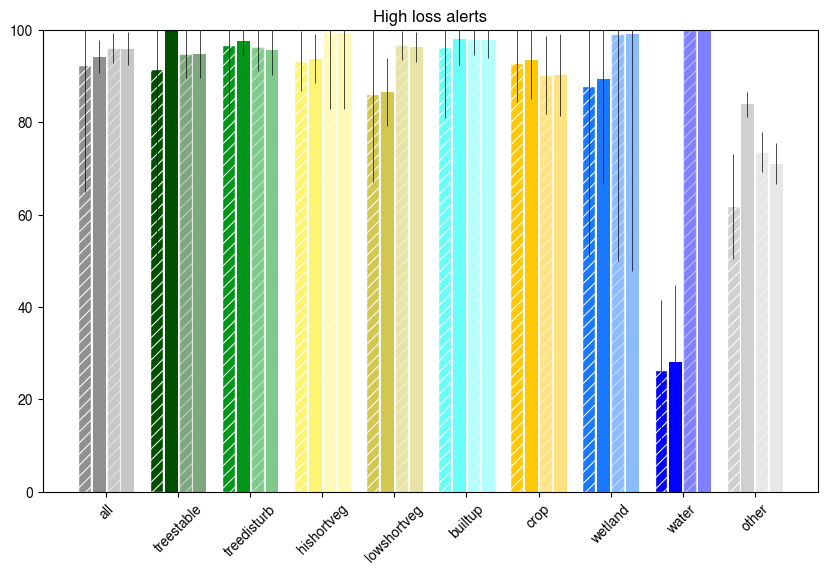

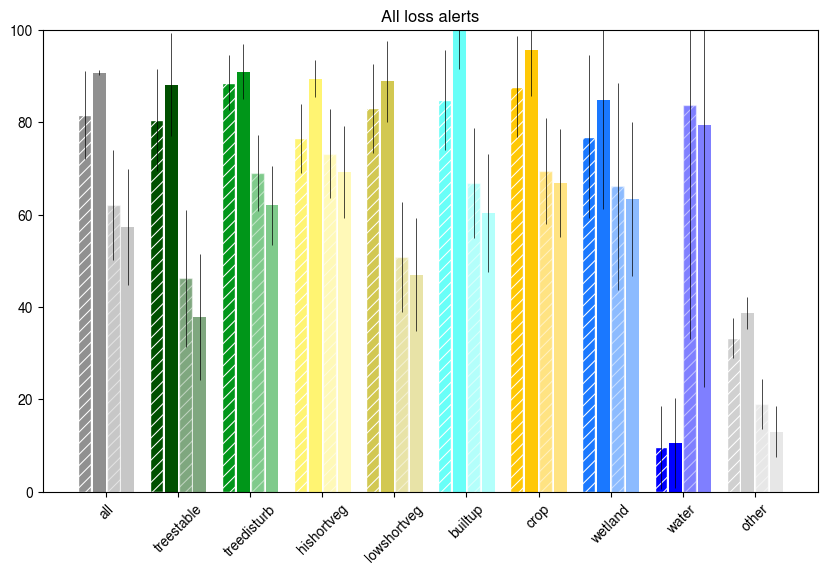

In [18]:
#accuracy 
import pandas as pd
plt.style.use('default')

dfU = pd.DataFrame(U.values())
dfUSE = pd.DataFrame(USE.values())
dfP = pd.DataFrame(P.values())
dfPSE = pd.DataFrame(PSE.values())

lookback = '30'
duration = '10'

df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","water","all"],
                   U["provgt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   U["confgt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   P["provlt50_lookback"+lookback+"_duration"+duration],
                   P["conflt50_lookback"+lookback+"_duration"+duration]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersconf","prod","prodconf"]
#print (df.iloc[[9,1,2,5,6,0,3,4,8,7]])
df = df.iloc[[9,1,2,5,6,0,3,4,8,7]]
print (df)

#strats = ["builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","water","all"]#"water"
strats = ["all","treestable","treedisturb","hishortveg","lowshortveg","builtup","crop","wetland","water","other"]#"water"
#print(df["userslt50"])
x = np.arange(len(strats))
width=0.2
#print(x)

fig, ax = plt.subplots(figsize=(10,6))
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams['hatch.linewidth'] = 0.75
palette = ["#68fff8","#005000","#009619","#ffc806","#1A78FF","#fff472","#d2c851","#d0d0d0","#0000ff","#909090"]
#palette = ["#909090","#68fff8","#005000","#009619","#ffc806","#1A78FF","#fff472","#d2c851","#d0d0d0","#0000ff"]
palette = [palette[9],palette[1],palette[2],palette[5],palette[6],palette[0],palette[3],palette[4],palette[8],palette[7]]
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=USE["gt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=USE["confgt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=PSE["lt50_lookback"+lookback+"_duration"+duration],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=PSE["conflt50_lookback"+lookback+"_duration"+duration],color=palette,alpha=0.5,error_kw=dict(lw=0.5))
#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("High loss alerts")
plt.savefig("accuracyLC.pdf",bbox_inches='tight')
fig.show()


df = pd.DataFrame([["Builtup","treestable","treedisturb","crop","wetland","hishortveg","lowshortveg","other","water","all"],
                   U["provlt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   U["conflt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   P["provlt50_lookback"+lookback+"_duration"+duration+"_VLmin"],
                   P["conflt50_lookback"+lookback+"_duration"+duration+"_VLmin"]]
                   )
df = df.transpose()
df.columns = ["landcover","users","usersconf","prod","prodconf"]
df = df.iloc[[9,1,2,5,6,0,3,4,8,7]]
print (df)
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x-width*1.5,df["users"],width-width*0.1,yerr=USE["provlt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x-width*0.5,df["usersconf"],width-width*0.1,yerr=USE["conflt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,error_kw=dict(lw=0.5))
ax.bar(x+width*0.5,df["prod"],width-width*0.1,yerr=PSE["provlt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,alpha=0.5,error_kw=dict(lw=0.5),hatch='///',edgecolor="white")
ax.bar(x+width*1.5,df["prodconf"],width-width*0.1,yerr=PSE["conflt50_lookback"+lookback+"_duration"+duration+"_VLmin"],color=palette,alpha=0.5,error_kw=dict(lw=0.5))
#ax = plt.gca()
ax.set_ylim([0, 100])
ax.set_xticks(range(0,10))
ax.set_xticklabels(strats,rotation=45)
ax.set_title("All loss alerts")
plt.savefig("accuracyLC_allalerts.pdf",bbox_inches='tight')

fig.show()

## Timeliness

#### Functions

In [19]:
sampleDict = {}
sampleFull = {}
strata = {}
strataNoAlert = {}
landcoverS = {}
lossyear = {}
with open("sampledpixels_original.csv","r") as sample:
  lines = sample.readlines()[1:]
  for l in lines:
    (ID,Stratum,landcover,alertstrata,Long,Lat,zone,x,y,pixel,pline,centxUTM,centyUTM,MGRS,forestLossYear) = l.strip().split(",")
    sampleDict[ID] = ",".join([Long,Lat,zone,centxUTM,centyUTM])
    sampleFull[ID] = l.strip()
    strata[ID] = int(Stratum)
    if Stratum == "1":
      strataNoAlert[ID] = "1_"+landcover
    landcoverS[ID] = int(landcover)
    lossyear[ID] = int(forestLossYear)+2000
allIDs = sampleDict.keys()

#Strata area
strataAreas = {}
strataCounts = {}
allStrata = []
totalArea = 0
with open("stratatable_nosplit.txt","r") as file:
  lines = file.readlines()[1:]
for l in lines:
  (s,count,area,K,zcount) = l.strip().split("\t")
  strataAreas[s] = float(area)
  strataCounts[s] = math.ceil(float(area)/(900/1000000))
  allStrata.append(int(s))
  totalArea += float(area)
Nstrata = len(strataCounts)

with open("stratatable.txt","r") as file:
  lines = file.readlines()[1:]

for l in lines:
  (s,count,area,K,zcount) = l.strip().split("\t")
  if int(s)%5 == 1:
    landcover = str(int((int(s)-1)/5)+1)
    strataAreas["1_"+landcover] = float(area)
    strataCounts["1_"+landcover] = math.ceil(float(area)/(900/1000000))

In [20]:
def getRefALERTDateDaily(yeslabels,nolabels,adjusted):
  refdate = {}
  deltalist = [ [] for s in range(Nstrata+1)]
  with open("referenceTimeSeriesInterpolated16.csv",'r') as mapfile:
    lines = mapfile.readlines()
    header = lines[0]
    reflist = lines[1:]
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype) = fields[0:5]
    daily = fields[5:]
    refdate[ID] = [-1 for i in range(0,365)]
    for day in range(0,365):
      found = False
      for l in yeslabels:
        if l == daily[day]:
          found = True
        #if l in daily[day] and int(ID) in refVLmaj:
        #  found = True
      if found:
        if day==0:
            refdate[ID][day] = 1
        elif refdate[ID][day-1]>0:
            refdate[ID][day] = refdate[ID][day-1]
        elif refdate[ID][day-1] == 0:
            refdate[ID][day] = day+1
        else:
            i=1
            while((day-i)>=0 and refdate[ID][day-i]==-1):#potentially could have loss nodat loss...
                i+=1
            if refdate[ID][day-i]>0:
                refdate[ID][day] = refdate[ID][day-i]
            else:
                deltalist[strata[ID]].append((i/2))
            if adjusted:
                refdate[ID][day] = (day-i/2)+1
            else:
                refdate[ID][day] = day+1
      else:
        for l in nolabels:
          if l == daily[day]:
            found = True
        if found:
          refdate[ID][day] = 0
        else:
          refdate[ID][day] = -1
  return (refdate,deltalist)

In [21]:
def getDISTALERTDate_vI(skipNodata,adjusted,ids=allIDs):
    mapdate = {}
    for ID in ids:
      if ID != "1323":
        mapdate[ID] = [-1 for i in range(0,366)]
        with open(mapsource+'/'+ID+'_DIST-ALERT_'+ANNname+'.csv','r') as mapfile:
            lines = mapfile.readlines()
        header = lines[0]
        maplist = lines[1:]
        for line in maplist:
            (granuleID,SensingTime,ProductionTime,VEGDISTSTATUS,VEGANOM,VEGIND,VEGHIST,VEGANOMMAX,VEGDISTCONF,VEGDISTDATE,VEGDISTCOUNT,VEGDISTDUR,VEGLASTDATE,GENDISTSTATUS,GENANOM,GENANOMMAX,GENDISTCONF,GENDISTDATE,GENDISTCOUNT,GENDISTDUR,GENLASTDATE)= line.strip().split(',')
            day = dayDiff("20230101",SensingTime)
            
            #if not (skipNodata and int(VEGANOM)==255):
            if VEGDISTSTATUS == '255' and mapdate[ID][day] == -1:
                mapdate[ID][day] = -1
                #print("status")
            elif skipNodata and VEGANOM=='255' and mapdate[ID][day] == -1:#VEGDISTDATE == "NA" and VEGIND==255:
                mapdate[ID][day] = -1
                #print("anom")
            elif VEGDISTDATE == 'NA':
                mapdate[ID][day] = 0
                #print("NA")
            else:
                if adjusted:
                    i=1
                    while((day-i)>=1 and mapdate[ID][day-i]==-1):
                       i+=1
                    if day-1>=1:
                        if mapdate[ID][day-i] == 0:
                            mapdate[ID][day] = (day-i/2)
                        else:
                            mapdate[ID][day] = mapdate[ID][day-i]#dayDiff("20211001",VEGDISTDATE)
                    else:
                        mapdate[ID][day-i] == dayDiff("20230101",VEGDISTDATE)/2
                else:
                    mapdate[ID][day] = dayDiff("20230101",VEGDISTDATE)
                    #print("day",dayDiff("20230101",VEGDISTDATE))
            
    return mapdate

In [22]:
def getMean(deltalist):
    N = strataCounts
    Nstrata = len(strataCounts)
    Ntotal = sum([N[str(s)] for s in allStrata])
    
    denom = 0
    deltaSum = 0
    variance = 0
    for s in allStrata:
        scount = len(deltalist[s])
        if scount>0:
            smean = sum(deltalist[s])/scount
            if scount > 1:
                ssum = 0
                for i in deltalist[s]:
                    ssum += (i-smean)**2
                sv = (1/(scount-1))*ssum
                variance += (N[str(s)]/Ntotal)**2 * ((N[str(s)]-scount)/(N[str(s)]-1)) * sv/scount
                #variance += (N[str(s)])**2 * ((N[str(s)]-aCount[s])/(N[str(s)]-1)) * sv/aCount[s]
                #print(s,aCount[s],smean,math.sqrt(sv))
            
            denom += (scount * (N[str(s)]))
            deltaSum += smean * (scount * (N[str(s)]))
            
    sampleMean = deltaSum/denom
    SE = math.sqrt(variance)
            
    return (sampleMean,SE)#,deltaDate)

In [23]:
def estimateDetectionLag(cat,map,ref,mapdate,refdate,strataCounts,mincount,excludelist,Ndays,ids=allIDs):
    N = strataCounts
    Nstrata = len(strataCounts)
    Ntotal = sum([N[str(s)] for s in allStrata])
    ndeltaSum = [0 for s in range(Nstrata+1)]
    nCount = [0 for s in range(Nstrata+1)]
    aCount = [0 for s in range(Nstrata+1)]
    deltaList = [ [] for s in range(Nstrata+1)]

    deltaDate = {}
    #confusion matrix
    for ID in ids:
      if ID != '1323':
        ptotal = 0
        atotal = 0
        deltaTotal = 0
        deltaDate[ID] = [-1 for i in range(0,365)]
        for d in range(0,365):
            #print(ref[ID][d], map[ID][d])
            if not int(ID) in excludelist:
                if max(ref[ID][0:(d+1)])>0 and map[ID][d] != 255 or map[ID][d] != 0 or mapdate[ID][d] != -1:
                    start = (d>Ndays)*(d-Ndays)
                    if map[ID][d] == 2:#active alert
                        if ref[ID][start:(d+mincount)].count(2) > mincount:#if ref also has alert
                            i=0
                            while(refdate[ID][d-i]<=0):#go back to first ref date with date
                                i+=1
                            deltaDate[ID][d] = mapdate[ID][d]-refdate[ID][d-i]
                            if deltaDate[ID][d]<0:
                                deltaDate[ID][d] = 0
                            deltaTotal +=deltaDate[ID][d] #sum total delta
                            atotal += 1 #count total dates of alert
                            ptotal += 1 #count total dates with data
                        elif ref[ID][start:(d+1)].count(1) > 0: #if ref has no alert
                            ptotal += 1 #count total dates with data
                    if map[ID][d] == 1:
                        if ref[ID][start:(d+mincount)].count(2) > mincount or ref[ID][start:(d+1)].count(1) > 0: # ref has data
                            ptotal += 1 #count total dates with data
        #print(ID)    
        if ptotal>0: #if dates with data
            nCount[strata[ID]] += 1 #add count to strata
        if atotal>0: # if alert dates
            aCount[strata[ID]] += 1 # add count of alert pixels to strata
            ndeltaSum[strata[ID]] += (deltaTotal/atotal) #average delta for pixel
            deltaList[strata[ID]].append(deltaTotal/atotal) # append average delta to strata list
        
    (sampleMean,SE) = getMean(deltaList)
    
    return (sampleMean,SE)#,deltaDate)

In [24]:
def printDictionary(dict,name):
    with open(name,'w') as OUT:
        for i in dict.keys():
            days = dict[i]
            OUT.write(i+","+','.join(str(x) for x in days)+"\n")

In [25]:

def alertConfusionMatrix_lag(map,ref,mapdate,refdate,strataCounts,mincount,excludelist,Ndays,name,lagx,printMatrix = False,ids=allIDs):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in allStrata])
  n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
  ntotal = [0 for s in range(Nstrata+1)]

  #enum Status {NODIST=0,FIRSTLO=1, PROVLO=2,CONFLO=3,FIRSTHI=4,PROVHI=5,CONFHI=6,CONFLOFIN=7,CONFHIFIN=8,NODATA=255};

  #confusion matrix
  for ID in ids:
    if ID != '1323':
      p = [[0,0,0],[0,0,0],[0,0,0]]
      ptotal = 0
      for d in range(0,365):
            if map[ID][d] <=2:
                mapVal =map[ID][d]
            else:
                mapVal = 0
            refVal=ref[ID][d]
            
            if refVal>0 and mapVal>0:
                #if refVal==2:
                #    print(ID, d,ref[ID][d],map[ID][d])
                p[refVal][mapVal] += 1
                ptotal += 1
    
    if ptotal>0:
      #if p[1][2]/ptotal >0 and p[2][2]==0:#or p[2][1]/ptotal >0
      #  print(ID, strata[ID], "true: ",round(p[2][2]/ptotal,3),"comm: ", round(p[1][2]/ptotal,3), "om: ", round(p[2][1]/ptotal,3))
      with open(name+".txt",'a') as OUT:
        OUT.write(str(ID)+","+str(p[1][1])+","+str(p[1][2])+","+str(p[2][1])+","+str(p[2][2])+","+str(ptotal)+"\n")
      ntotal[strata[ID]] += (p[1][1]+p[1][2]+p[2][1]+p[2][2])/ptotal
      for r in [1,2]:
        for m in [1,2]:
          n[strata[ID]][r][m] += (p[r][m]/ptotal)
    #print(ptotal,end=",")
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in range(1,Nstrata):
      for r in (1,2):
        for m in (1,2):
          print(n[s][r][m],end=",")
      print()
  return (n,ntotal)

In [26]:
def convertRef(ref,mincount,Ndays,ids=allIDs):
    N = strataCounts
    Nstrata = len(strataCounts)
    Ntotal = sum([N[str(s)] for s in allStrata])
    n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
    ntotal = [0 for s in range(Nstrata+1)]
    #enum Status {NODIST=0,FIRSTLO=1, PROVLO=2,CONFLO=3,FIRSTHI=4,PROVHI=5,CONFHI=6,CONFLOFIN=7,CONFHIFIN=8,NODATA=255};
    refout = {}
    #confusion matrix
    for ID in ids:
        refout[ID] = [0 for d in range(0,365)]
        p = [[0,0,0],[0,0,0],[0,0,0]]
        ptotal = 0
        for d in range(0,365):
            #if max(ref[ID][0:(d+1)])>0:
                start = (d>Ndays)*(d-Ndays)
                if ref[ID][start:(d+mincount)].count(2) > mincount:
                    refout[ID][d]=2
                elif ref[ID][start:(d+1)].count(1) > 0:
                    refout[ID][d]=1
                else:
                    refout[ID][d]=0
    return refout

In [27]:
map = getDISTALERTStatus_vI(True)
mapNoSkipND = getDISTALERTStatus_vI(False)

1323 OPERA_L3_DIST-ALERT-HLS_T19HFC_20230219T142709Z_20231221T042133Z_S2B_30_v1_VEG-DIST-STATUS,20230219,2023-12-21 04:21:33,,,,,,
1323 OPERA_L3_DIST-ALERT-HLS_T19HFC_20230219T142709Z_20231221T042133Z_S2B_30_v1_VEG-DIST-STATUS,20230219,2023-12-21 04:21:33,,,,,,


#### Latency

In [28]:
for cattype in ["lt50","gt50","provgt50","provlt50"]:#,"lt50"]:#,"confgt50","conflt50"]:
    basename = cattype
    #map = getDISTALERTStatus_vI(True)
    mapsimple = filterMap(map,cattype)
    mapdate = getDISTALERTDate_vI(True,False)
    printDictionary(mapdate,"mapv1_date_skipND.csv")
    for refAdj in [True,False]:
        for duration in [10]:#,5,10,15]:
            for lookback in [30]:#1,15,30]:
                name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
                noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
                ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal","VLmin"],noLabels,IDlist=allIDs)
                (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,refAdj)
                (refunc,ruSE) = getMean(refuncList)
                (lag,SE) = estimateDetectionLag(cattype,mapsimple,ref,mapdate,refdate,strataCounts,duration,[],lookback)
                (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name)
                printDictionary(refdate,"refdate_"+name+"adj"+str(refAdj)+".csv")
                print("Skip no new data dates",name, round(lag,2),"+/-",round(SE,2),"day mean lag,",round(refunc,2),"+/-",round(ruSE,2),"day mean uncertainty in the reference data\n")

    mapsimple = filterMap(mapNoSkipND,cattype)
    mapdate = getDISTALERTDate_vI(False,False)
    printDictionary(mapdate,"mapv1_date.csv")
    for refAdj in [True,False]:
        for duration in [10]:#,5,10,15]:
            for lookback in [30]:#1,15,30]:
                name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
                noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
                ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal","VLmin"],noLabels,IDlist=allIDs)
                (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,refAdj)
                (refunc,ruSE) = getMean(refuncList)
                (lag,SE) = estimateDetectionLag(cattype,mapsimple,ref,mapdate,refdate,strataCounts,duration,[],lookback)
                (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name)
                printDictionary(refdate,"refdate_"+name+"adj"+str(refAdj)+".csv")
                print("All granule dates",name, round(lag,2),"+/-",round(SE,2),"day mean lag,",round(refunc,2),"+/-",round(ruSE,2),"day mean uncertainty in the reference data\n")

Skip no new data dates lt50_lookback30_duration10_VLmin 18.19 +/- 0.4 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

Skip no new data dates lt50_lookback30_duration10_VLmin 14.54 +/- 0.37 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

All granule dates lt50_lookback30_duration10_VLmin 17.65 +/- 0.4 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

All granule dates lt50_lookback30_duration10_VLmin 14.07 +/- 0.37 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

Skip no new data dates gt50_lookback30_duration10_VLmin 9.7 +/- 0.01 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

Skip no new data dates gt50_lookback30_duration10_VLmin 6.12 +/- 0.01 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

All granule dates gt50_lookback30_duration10_VLmin 9.56 +/- 0.01 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

All granule dates gt

In [29]:
mapsource = "mapLabels2023"
for cattype in ["lt50","gt50","provgt50","provlt50"]:#,"lt50"]:#,"confgt50","conflt50"]:
    basename = cattype
    #map = getDISTALERTStatus_vI(True)
    mapsimple = filterMap(map,cattype)
    mapdate = getDISTALERTDate_vI(True,False)
    printDictionary(mapdate,"mapv1_date_skipND.csv")
    for refAdj in [True,False]:
        for duration in [10]:#,5,10,15]:
            for lookback in [30]:#1,15,30]:
                name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
                noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
                ref = getRefALERTbinaryDaily("referenceTimeSeries.csv",["VLmaj","VLtotal","VLmin"],noLabels,IDlist=allIDs)
                (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,refAdj)
                (refunc,ruSE) = getMean(refuncList)
                (lag,SE) = estimateDetectionLag(cattype,mapsimple,ref,mapdate,refdate,strataCounts,duration,[],lookback)
                (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name)
                printDictionary(refdate,"refdate_"+name+"adj"+str(refAdj)+".csv")
                print("Skip no new data dates",name, round(lag,2),"+/-",round(SE,2),"day mean lag,",round(refunc,2),"+/-",round(ruSE,2),"day mean uncertainty in the reference data\n")

    mapsimple = filterMap(mapNoSkipND,cattype)
    mapdate = getDISTALERTDate_vI(False,False)
    printDictionary(mapdate,"mapv1_date.csv")
    for refAdj in [True,False]:
        for duration in [10]:#,5,10,15]:
            for lookback in [30]:#1,15,30]:
                name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)+"_VLmin"
                noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
                ref = getRefALERTbinaryDaily("referenceTimeSeries.csv",["VLmaj","VLtotal","VLmin"],noLabels,IDlist=allIDs)
                (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,refAdj)
                (refunc,ruSE) = getMean(refuncList)
                (lag,SE) = estimateDetectionLag(cattype,mapsimple,ref,mapdate,refdate,strataCounts,duration,[],lookback)
                (n,ntotal) = alertConfusionMatrix_vTS2(mapsimple,ref,duration,lookback,name)
                printDictionary(refdate,"refdate_"+name+"adj"+str(refAdj)+".csv")
                print("All granule dates",name, round(lag,2),"+/-",round(SE,2),"day mean lag,",round(refunc,2),"+/-",round(ruSE,2),"day mean uncertainty in the reference data\n")

Skip no new data dates lt50_lookback30_duration10_VLmin 19.52 +/- 0.38 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

Skip no new data dates lt50_lookback30_duration10_VLmin 15.52 +/- 0.35 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

All granule dates lt50_lookback30_duration10_VLmin 18.96 +/- 0.51 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

All granule dates lt50_lookback30_duration10_VLmin 15.05 +/- 0.48 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

Skip no new data dates gt50_lookback30_duration10_VLmin 9.86 +/- 0.01 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

Skip no new data dates gt50_lookback30_duration10_VLmin 6.19 +/- 0.01 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

All granule dates gt50_lookback30_duration10_VLmin 9.64 +/- 0.01 day mean lag, 8.71 +/- 0.52 day mean uncertainty in the reference data

All granule dates

#### Accuracy per time lag

In [30]:
#Skipping dates with no new data
lc = [1,2,3,4,5,6,7,8]
(selectedIDs,selectedStrata) = selectByLandCover(lc,False)
for cattype in ["provgt50"]:
    basename = cattype+"_VLmin"
    mapsimple = filterMap(map,cattype)
    mapdate = getDISTALERTDate_vI(True,False)
    for duration in [10]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal","VLmin"],noLabels)
        (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,True)
        print(name, "\n")
        usersND = []; usersNDSE = []
        producersND = [];producersNDSE = []
        for lagx in range(0,100):
            mapFiltered = {}
            for ID in mapdate.keys():
              mapFiltered[ID] = [0 for d in range(0,366)]
              if ID != '1323':
                for d in range(0,366):
                    mapFiltered[ID][d]=mapsimple[ID][d]
                    if (d - mapdate[ID][d])>lagx and mapsimple[ID][d]==2:
                        mapFiltered[ID][d] =0
                    elif mapdate[ID][d] > 0 and mapsimple[ID][d]==2:
                        last = min(mapdate[ID][d]+lagx,365)
                        mapVal = 0
                        for x in range(mapdate[ID][d],last):
                            if mapsimple[ID][x] !=0:
                                mapVal = mapsimple[ID][x]
                        if mapVal == 1:
                            if ID == '335':
                                print(map[ID][mapdate[ID][d]:last])
                            for x in range(mapdate[ID][d],last):
                                if mapsimple[ID][x]==2:
                                    mapFiltered[ID][x]=0
            (n,ntotal) = alertConfusionMatrix_lag(mapFiltered,ref,mapdate,refdate,strataCounts,duration,[],lookback,name,lagx,False)
            usersND.append(usersAccuracy(n,ntotal,name,selectedStrata))

#All granule dates
for cattype in ["provgt50"]:
    basename = cattype+"_VLmin"
    mapsimple = filterMap(mapNoSkipND,cattype)
    mapdate = getDISTALERTDate_vI(False,False)
     
    for duration in [10]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal","VLmin"],noLabels)
        (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal","VLmin"],noLabels,True)
        print(name, "\n")
        users = []; usersSE = []
        producers = [];producersSE = []
        for lagx in range(0,100):
            mapFiltered = {}
            for ID in mapdate.keys():
              mapFiltered[ID] = [0 for d in range(0,366)]
              if ID != '1323':
                for d in range(0,366):
                    mapFiltered[ID][d]=mapsimple[ID][d]
                    if (d - mapdate[ID][d])>lagx and mapsimple[ID][d]==2:
                        mapFiltered[ID][d] =0
                    elif mapdate[ID][d] > 0 and mapsimple[ID][d]==2:
                        last = min(mapdate[ID][d]+lagx,365)
                        mapVal = 0
                        for x in range(mapdate[ID][d],last):
                            if mapsimple[ID][x] !=0:
                                mapVal = mapsimple[ID][x]
                        if mapVal == 1:
                            for x in range(mapdate[ID][d],last):
                                if mapsimple[ID][x]==2:
                                    mapFiltered[ID][x]=0

            (n,ntotal) = alertConfusionMatrix_lag(mapFiltered,ref,mapdate,refdate,strataCounts,duration,[],lookback,name,lagx,False)
            users.append(usersAccuracy(n,ntotal,name,selectedStrata))



provgt50_VLmin_lookback30_duration10 

provgt50_VLmin_lookback30_duration10 



In [31]:
for cattype in ["provlt50"]:
    basename = cattype
    mapsimple = filterMap(map,cattype)
    mapdate = getDISTALERTDate_vI(True,False)
    for duration in [10]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal"],noLabels)
        (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal"],noLabels,False)
        ref = convertRef(ref,duration,lookback)
        print(name, "\n")
        producersND = [];producersNDSE = []
        for lagx in range(0,100):
            refFiltered = {}
            for ID in allIDs:
                refFiltered[ID] = [0 for d in range(0,365)]
                for d in range(0,365):
                    refFiltered[ID][d]=ref[ID][d]
                    if (d - refdate[ID][d])>lagx and ref[ID][d]==2:
                        refFiltered[ID][d] =0
            (n,ntotal) = alertConfusionMatrix_lag(mapsimple,refFiltered,mapdate,refdate,strataCounts,duration,[],lookback,name,lagx,False)
            producersND.append(producersAccuracy(n,ntotal,name,selectedStrata))

for cattype in ["provlt50"]:
    basename = cattype
    mapsimple = filterMap(mapNoSkipND,cattype)
    mapdate = getDISTALERTDate_vI(False,False)
    for duration in [10]:#,5,10,15]:
      for lookback in [30]:#1,15,30]:
        name = basename+"_lookback"+str(lookback)+"_duration"+str(duration)
        noLabels = ["OCmin","OCmaj","OCtotal","noChange","VLmin"]
        ref = getRefALERTbinaryDaily("referenceTimeSeriesInterpolated16.csv",["VLmaj","VLtotal"],noLabels)
        (refdate,refuncList) = getRefALERTDateDaily(["VLmaj","VLtotal"],noLabels,False)
        ref = convertRef(ref,duration,lookback)
        print(name, "\n")
        producers = [];producersSE = []
        for lagx in range(0,100):
            refFiltered = {}
            for ID in allIDs:
                refFiltered[ID] = [0 for d in range(0,365)]
                for d in range(0,365):
                    refFiltered[ID][d]=ref[ID][d]
                    if (d - refdate[ID][d])>lagx and ref[ID][d]==2:
                        refFiltered[ID][d] =0

            (n,ntotal) = alertConfusionMatrix_lag(mapsimple,refFiltered,mapdate,refdate,strataCounts,duration,[],lookback,name,lagx,False)

            producers.append(producersAccuracy(n,ntotal,name,selectedStrata))

provlt50_lookback30_duration10 

provlt50_lookback30_duration10 



/apps/python/3.7/anaconda/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSans-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


[        nan 69.09963959 75.61558616 77.48081134 79.36526072 78.47390087
 80.68805463 83.49748041 85.34311647 87.45437778 88.23726087 88.67194559
 88.52208775 88.50422583 88.95188487 89.70594998 91.48653953 92.41040045
 92.89116953 92.56294022 92.76909656 93.01536419 93.2675265  93.08637032
 92.46777577 92.69530725 92.99997382 93.12484346 93.19507478 93.25819562
 93.62422334 93.97152034 94.22530553 94.2672718  94.31579564 94.45489986
 94.39115504 94.52980029 94.57804413 94.61287272 94.55995921 94.47508956
 94.47866511 94.51065248 94.56648757 94.17984026 94.20086332 94.31045365
 94.26239852 94.2359409  94.20428951 94.2431008  94.1886973  94.3910899
 94.41763186 94.2672837  94.24558717 94.34371254 94.18971825 94.16218743
 94.03200809 94.00887181 94.04644716 94.0496055  93.94832587 93.93937486
 93.90343838 93.8139791  93.79759515 93.81665393 93.74958163 93.76891354
 93.81190126 93.81713268 93.80951113]
[79.45254211 77.84088917 80.97207673 81.42941596 84.92408247 86.49222221
 88.5081415  8

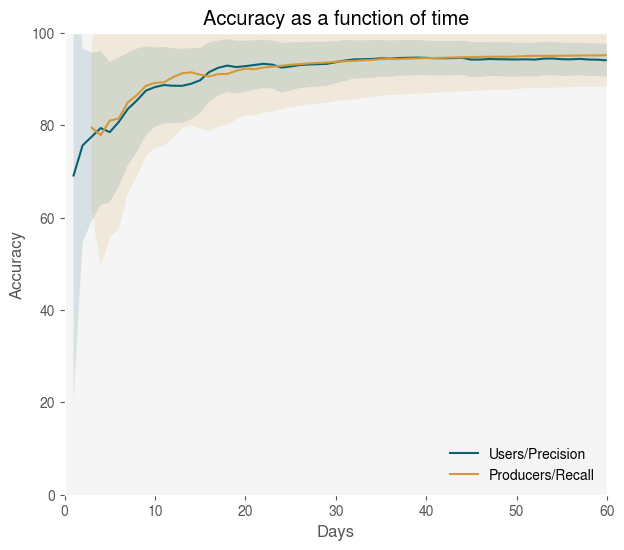

In [32]:
import matplotlib
matplotlib.style.use('ggplot')

endindex = 75
xu = range(0,endindex)
xp = range(3,endindex+3)
plt.figure(figsize=(7,6))
pal = ["#D49937","#2E7B8A"]
pal = ["#066274","#D49937"]#,"#2E7B8A"]
#pal = ["#066274","#74A57F"]#"#598863"]
yuall = np.array([row[0] for row in usersND[0:endindex]])
yuerr = np.array([row[1] for row in usersND[0:endindex]])
ypall = np.array([row[0] for row in producersND[0:endindex]])
yperr = np.array([row[1] for row in producersND[0:endindex]])
print(yuall)
print(ypall)
labs = ['Users: >=50, VLmin','Producers: <50, VLmin']

plt.fill_between(xu, yuall-yuerr, yuall+yuerr,facecolor=pal[0]+'22',linewidth=0.1)
plt.plot(xu,yuall,color=pal[0],label='Users/Precision')
plt.fill_between(xp, ypall-yperr, ypall+yperr,facecolor=pal[1]+'22',linewidth=0.1)
plt.plot(xp,ypall,color=pal[1],label='Producers/Recall')
leg2 = plt.legend(reversed(labs),bbox_to_anchor=(1.04,1),loc='upper left',framealpha=0)
plt.setp(leg2.get_texts(), color='#444444')
plt.legend(loc='lower right',framealpha=0)
plt.ylim(0,100)
plt.xlim(0,60)
plt.title('Accuracy as a function of time')# excluding dates with no new observation')
plt.ylabel('Accuracy')#²')
plt.xlabel('Days')#²')
plt.grid(False)
plt.axes().set_facecolor("#f5f5f5")
plt.savefig("accuracyTimeExcludeNoData.pdf",bbox_inches='tight')
plt.show()

## DIST-ANN accuracy

#### Functions

In [33]:
def getDISTANNbinary(yes,nodata,threshold=False):
  with open(mapsource + '/All_DIST-ANN_'+ANNname+'.csv','r') as mapfile:
    maplist = mapfile.readlines()[1:]
  mapann = {}
  for line in maplist:
    (ID,Stratum,Long,Lat,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_IND_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_DUR,VEG_DIST_COUNT,GEN_DIST_STATUS,GEN_ANOM_MAX,GEN_DIST_CONF,GEN_DIST_DATE,GEN_DIST_DUR,GEN_DIST_COUNT) = line.strip().split(',')
    if not threshold:
      if int(VEG_DIST_STATUS) in yes:
        mapann[ID] = 2
      elif int(VEG_DIST_STATUS) in nodata:
        mapann[ID] = 0
      else:
        mapann[ID] = 1
    else:
      if int(VEG_DIST_STATUS) in yes and int(VEG_ANOM_MAX) >= threshold:
        mapann[ID] = 2
      elif int(VEG_DIST_STATUS) in nodata:
        mapann[ID] = 0
      else:
        mapann[ID] = 1
  return mapann

In [34]:
def getRefANNbinaryFilterDaily(yeslabels,maybelabels,yesmincount,maybemincount):
  with open('referenceTimeSeriesInterpolated16.csv','r') as reffile:
    reflist = reffile.readlines()[1:]
  refann = {}
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype)=fields[0:5]
    labels = fields[5:]
    yescount = 0
    maybecount = 0
    datacount = 0
    first = 0
    for l in labels:
      if l != "noObs" and first == 0:
        first = l
      if l in yeslabels:
        yescount +=1
      elif l in maybelabels:
        maybecount +=1
      if l != "noObs":
        datacount +=1
    if yescount >= yesmincount or maybecount >=maybemincount:# and not first in yeslabels:
      refann[ID] = 2
    elif datacount >= 1:
      refann[ID] = 1
    else:
      refann[ID] = 0
  return refann

def getRefANNbinary(yeslabels,maybelabels,yesmincount,maybemincount):
  with open('referenceTimeSeriesInterpolated16.csv','r') as reffile:
    reflist = reffile.readlines()[1:]
  refann = {}
  for line in reflist:
    fields = line.strip().split(',')
    (ID,overallLabel,Long,Lat,changetype)=fields[0:5]
    labels = fields[5:]
    yescount = 0
    maybecount = 0
    datacount = 0
    first = 0
    for l in labels:
      if l != "noObs" and first == 0:
        first = l
      if l in yeslabels:
        yescount +=1
      elif l in maybelabels:
        maybecount +=1
      if l != "noObs":
        datacount +=1
    if yescount >= yesmincount or maybecount >=maybemincount:# and not first in yeslabels:
      refann[ID] = 2
    elif datacount >= 1:
      refann[ID] = 1
    else:
      refann[ID] = 0
  return refann

In [35]:
def annualConfusionMatrix(map,ref,strataCounts,excludelist=[0],printMatrix = False):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in allStrata])
  #print("Total pixels:", Ntotal," Nstrata:",Nstrata)
  n = [[[0,0,0],[0,0,0],[0,0,0]] for s in range(Nstrata+1)]
  ntotal = [0 for s in range(Nstrata+1)]
  #print(excludelist)
  refVLmaj = []
  #confusion matrix
  for ID in allIDs:
    if int(ID) in refVLmaj:
      ref[ID] = 2
    n[strata[ID]][int(ref[ID])][int(map[ID])] += 1
    if ref[ID] >0 and map[ID]>0:
      ntotal[strata[ID]] += 1
  if printMatrix:
    print("r1m1,r1m2,r2m1,r2m2")
    for s in range(1,Nstrata):
      for r in (1,2):
        for m in (1,2):
          print(n[s][r][m],end=",")
      print()
  return (n,ntotal)

In [36]:
def getDISTANN_new(file,yes,nodata):
  with open(file+'.csv','r') as mapfile:
    maplist = mapfile.readlines()[1:]
  mapann = {}
  for line in maplist:
    (ID,Stratum,Long,Lat,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_COUNT,VEG_DIST_DUR,VEG_HIST,VEG_IND_MAX,VEG_CONF_COUNT,VEG_CONF_PREV,VEG_LAST_DATE,GEN_DIST_STATUS,GEN_ANOM_MAX,GEN_DIST_CONF,GEN_DIST_DATE,GEN_DIST_COUNT,GEN_DIST_DUR,GEN_CONF_COUNT,GEN_CONF_PREV,GEN_LAST_DATE) = line.strip().split(',')
    #(temp,ID,VEG_DIST_STATUS,VEG_ANOM_MAX,VEG_DIST_CONF,VEG_DIST_DATE,VEG_DIST_COUNT,VEG_DIST_DUR,VEG_HIST,VEG_IND_MAX) = line.strip().split(',')
    if int(VEG_DIST_STATUS) in yes:
       mapann[ID] = 2
    elif int(VEG_DIST_STATUS) in nodata:
       mapann[ID] = 0
    else:
       mapann[ID] = 1
  return mapann

In [37]:
def accuracy(n, ntotal, strataCounts,name,write=True):
  N = strataCounts
  Nstrata = len(strataCounts)
  Ntotal = sum([N[str(s)] for s in allStrata])

  #Accuracy
  overall = 0
  y = 0
  usersx = 0
  producersx = 0
  OAsub = 0
  area = [[0,0],[0,0]]
  for s in allStrata:
    #overall
    overall += ((n[s][1][1] + n[s][2][2])/ntotal[s])*(N[str(s)]/Ntotal)
    oyhmean = (n[s][1][1] + n[s][2][2])/ntotal[s]
    sampvaryhOA = ((n[s][1][1] + n[s][2][2])*((1-oyhmean)**2) + (n[s][1][2] + n[s][2][1])*((0-oyhmean)**2))/(ntotal[s]-1)
    OAsub += N[str(s)]*N[str(s)]*(1-ntotal[s]/N[str(s)])*sampvaryhOA/(ntotal[s])*(1/Ntotal**2)

    #users and producers
    y += (n[s][2][2]/ntotal[s])*N[str(s)]
    usersx += ((n[s][1][2]+n[s][2][2])/ntotal[s])*N[str(s)]
    producersx += ((n[s][2][1]+n[s][2][2])/ntotal[s])*N[str(s)]
    
    #print("strata",s,n[s][1][1],n[s][1][2],n[s][2][1],n[s][2][2])
    for i in range(1,3):
      for j in range(1,3):
        area[i-1][j-1] += (n[s][i][j]/ntotal[s])*(N[str(s)]/Ntotal)
  
  print(area[0][0]*100,area[0][1]*100)
  print(area[1][0]*100,area[1][1]*100)

  overall = overall*100
  overallSE = math.sqrt(OAsub)*100
  if usersx > 0:
    users = (y/usersx)
  else:
    users = "NA"
    usersSE = "NA"
  if producersx > 0:
    producers = (y/producersx)
  else:
    producers = "NA"
    producersSE = "NA"

  UAsub1 = 0
  UAsub2 = 0
  PAsub1 = 0
  PAsub2 = 0
  for s in allStrata:
    #users and producers
    yhmean = n[s][2][2]/ntotal[s]
    yhsampvar = ((n[s][2][2])*((1-yhmean)**2) + (n[s][1][1] + n[s][1][2] + n[s][2][1])*((0-yhmean)**2))/(ntotal[s]-1)
    
    if users != "NA":
        if (n[s][1][2]+n[s][2][2]) > 0:
            xuhmean = (n[s][1][2]+n[s][2][2])/ntotal[s]
            xuhsampvar = ((n[s][1][2]+n[s][2][2])*((1-xuhmean)**2) + (n[s][1][1] + n[s][2][1])*((0-xuhmean)**2))/(ntotal[s]-1)
            xyuhsampvar = (n[s][1][1] * (0-yhmean) * (0-xuhmean) + n[s][1][2] * (0-yhmean) * (1-xuhmean) + n[s][2][1] * (0-yhmean) * (0-xuhmean) + n[s][2][2] * (1-yhmean) * (1-xuhmean))/(ntotal[s] - 1)
            UAsub1 += N[str(s)]*xuhmean
            UAsub2 += N[str(s)]**2 * (1 - ntotal[s]/N[str(s)]) * (yhsampvar + (users**2)*xuhsampvar - 2*users*xyuhsampvar)/ntotal[s]
    
    if producers != "NA":
        if (n[s][2][1]+n[s][2][2]) > 0:
            xphmean = (n[s][2][1]+n[s][2][2])/ntotal[s]
            xphsampvar = ((n[s][2][1]+n[s][2][2])*((1-xphmean)**2) + (n[s][1][1] + n[s][1][2])*((0-xphmean)**2))/(ntotal[s]-1)
            xyphsampvar = (n[s][1][1] * (0-yhmean) * (0-xphmean) + n[s][1][2] * (0-yhmean) * (0-xphmean) + n[s][2][1] * (0-yhmean) * (1-xphmean) + n[s][2][2] * (1-yhmean) * (1-xphmean))/(ntotal[s] - 1)
            PAsub1 += N[str(s)]*xphmean
            PAsub2 += N[str(s)]**2 * (1 - ntotal[s]/N[str(s)]) * (yhsampvar + (producers**2)*xphsampvar - 2*producers*xyphsampvar)/ntotal[s]

  
  if users != "NA":
    usersSE = math.sqrt(1/(UAsub1**2) * UAsub2) * 100
    users = users*100
  else:
    usersSE = "NA"
  if producers != "NA":
    if PAsub1>0 and PAsub2 > 0:
      producersSE = math.sqrt(1/(PAsub1**2) * PAsub2) * 100
    else:
      producersSE = "NA"
    producers = producers*100
  else:
    producersSE = "NA"
  print("Overall:",overall," +-", overallSE)
  print("Users:",users," +-", usersSE)
  print("Producers:",producers," +-", producersSE)
  if write:
    with open("accuracy.csv",'a') as OUT:
        OUT.write(','.join([name,str(overall),str(overallSE),str(users),str(usersSE),str(producers),str(producersSE)])+"\n")

#### Calculation

In [38]:
#ANN
file = mapsource+"/All_DIST-ANN_2023"
basename = "DIST-ANN_v1"
durlist = [10,35,75]
for duration in durlist:
    name = basename+"_dur"+str(duration)+"_gt50"
    print("\n"+name)
    map = getDISTANN_new(file,[6,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj"],["VLmin"],duration,366)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    accuracy(n,ntotal,strataCounts,name,True)
    print(producersAccuracy(n, ntotal, name))
    
for duration in durlist:
    name = basename+"_dur"+str(duration)+"_lt50"
    print("\n"+name)
    map = getDISTANN_new(file,[3,6,7,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj"],["VLmin"],duration,366)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    accuracy(n,ntotal,strataCounts,name,True)
    
for duration in durlist:

    name = basename+"_dur"+str(duration)+"_gt50"+"_VLmin"
    print("\n"+name)
    map = getDISTANN_new(file,[6,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj","VLmin"],[],duration,366)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    accuracy(n,ntotal,strataCounts,name,True)
    
for duration in durlist:

    name = basename+"_dur"+str(duration)+"_lt50"+"_VLmin"
    print("\n"+name)
    map = getDISTANN_new(file,[3,6,7,8],[255])
    ref = getRefANNbinaryFilterDaily(["VLtotal","VLmaj","VLmin"],[],duration,366)
    (n,ntotal) = annualConfusionMatrix(map,ref,strataCounts,[0],False)
    accuracy(n,ntotal,strataCounts,name,True)


DIST-ANN_v1_dur10_gt50
98.38581186191892 0.36010796112395965
0.7070684113819461 0.5470117655751652
Overall: 98.9328236274941  +- 0.17944035786358895
Users: 60.30204718021738  +- 3.622584146653259
Producers: 43.61856407797063  +- 6.38428256828361
[43.61856407797063, 6.38428256828361]

DIST-ANN_v1_dur35_gt50
98.94720056750175 0.5831541261540989
0.14567970579914785 0.32396560054502593
Overall: 99.27116616804675  +- 0.08293963882877996
Users: 35.713653998451676  +- 3.367077441940849
Producers: 68.98090881964693  +- 11.311116924753572
[68.98090881964693, 11.311116924753572]

DIST-ANN_v1_dur75_gt50


99.05222508374679 0.808048084767397
0.040655189554095555 0.09907164193172792
Overall: 99.15129672567853  +- 0.03886429029885965
Users: 10.921561841923014  +- 1.8769516212275972
Producers: 70.90380628990334  +- 14.03429642793212
[70.90380628990334, 14.03429642793212]

DIST-ANN_v1_dur10_lt50
96.03218820991377 2.7137316131291427
0.3498377985251904 0.9042423784319209
Overall: 96.93643058834567  +- 0.26435082097418133
Users: 24.99305911377665  +- 3.215763835451002
Producers: 72.10403250500032  +- 8.371608241419139

DIST-ANN_v1_dur35_lt50
96.37952737227123 3.150827321384602
0.002498636167711656 0.4671466701764622
Overall: 96.8466740424477  +- 0.24250733618628798
Users: 12.911830523549462  +- 2.2539422548964048
Producers: 99.46797378064703  +- 0.2801633012914026

DIST-ANN_v1_dur75_lt50
96.38202600843896 3.4782471600752403
0.0 0.13972683148582346
Overall: 96.52175283992479  +- 0.24592162334829004
Users: 3.86201868260349  +- 0.8979912348291079
Producers: 100.0  +- 2.0792265477661874e-07

DIST-A